In [2]:
!find . -name "*.pyc" -delete
!find . -name "__pycache__" -delete
!pip install --no-deps git+https://github.com/GFNOrg/torchgfn.git

  Cloning https://github.com/GFNOrg/torchgfn.git to /tmp/pip-req-build-qiqqw6dl
  Running command git clone --filter=blob:none --quiet https://github.com/GFNOrg/torchgfn.git /tmp/pip-req-build-qiqqw6dl
  Resolved https://github.com/GFNOrg/torchgfn.git to commit 6f132a869902584c06b7f8054e76dda696d78c94
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torchgfn: filename=torchgfn-1.1.1-py3-none-any.whl size=76301 sha256=4b73bdf29bf87b9618bb1f34602c8c9f28fa6e5c1c03f282dfa43aae90841036
  Stored in directory: /tmp/pip-ephem-wheel-cache-yxn4av_f/wheels/a5/81/2c/dc48ab4e10a8e2b5bbdc8f4311c543508b3b58e4d4b6a0e1df
Successfully built torchgfn


In [3]:
import torch
from tqdm import tqdm

from gfn.gflownet import TBGFlowNet
from gfn.gym import HyperGrid  # We use the hyper grid environment
from gfn.modules import DiscretePolicyEstimator
from gfn.samplers import Sampler
from gfn.utils.modules import MLP  # is a simple multi-layer perceptron (MLP)
from gfn.containers import Trajectories
from gfn.states import States

This modified hypergrid environment is parametrized by $n$ normal distributions $\{\mathbb{N}(⋅|\mu_i, Σ_i)\}_{i=1}^n$. Each sample $x$ has probability density
$$p(x)=\frac{\sum_{i=1}^n\mathbb{N}(x|\mu_i, Σ_i)}{n}$$

In [4]:
"""
Customized Hypergrid environment that is easy to sample from
by Yue Zhang, Nov 18, 2024
"""
import torch

from typing import Literal, Tuple


from einops import rearrange

from gfn.containers import Trajectories
from gfn.actions import Actions
from gfn.states import States
from gfn.env import DiscreteEnv
from gfn.gym.helpers.preprocessors import KHotPreprocessor, OneHotPreprocessor
from gfn.preprocessors import EnumPreprocessor, IdentityPreprocessor
from gfn.states import DiscreteStates


class HyperGrid2(DiscreteEnv):
    def __init__(
        self,
        ndim: int = 2,
        height: int = 4,
        seed: int = 1953,
        ncenters: int = 5,
        centers: torch.tensor or None = None,
        device_str: Literal["cpu", "cuda"] = "cpu",
        preprocessor_name: Literal["KHot", "OneHot", "Identity", "Enum"] = "KHot",
    ):
        """HyperGrid environment from the GFlowNets paper.
        The states are represented as 1-d tensors of length `ndim` with values in
        {0, 1, ..., height - 1}.
        A preprocessor transforms the states to the input of the neural network,
        which can be a one-hot, a K-hot, or an identity encoding.

        Args:
            ndim (int, optional): dimension of the grid. Defaults to 2.
            height (int, optional): height of the grid. Defaults to 4.
            seed: seed used to initialize the centers of normal distribution
            ncenters: the number of centers
            reward_cos (bool, optional): Which version of the reward to use. Defaults to False.
            device_str (str, optional): "cpu" or "cuda". Defaults to "cpu".
            preprocessor_name (str, optional): "KHot" or "OneHot" or "Identity". Defaults to "KHot".
        """
        self.ndim = ndim
        self.height = height
        self.seed = seed
        self.ncenters = ncenters

        s0 = torch.zeros(ndim, dtype=torch.long, device=torch.device(device_str))
        sf = torch.full(
            (ndim,), fill_value=-1, dtype=torch.long, device=torch.device(device_str)
        )
        n_actions = ndim + 1

        if preprocessor_name == "Identity":
            preprocessor = IdentityPreprocessor(output_dim=ndim)
        elif preprocessor_name == "KHot":
            preprocessor = KHotPreprocessor(height=height, ndim=ndim)
        elif preprocessor_name == "OneHot":
            preprocessor = OneHotPreprocessor(
                n_states=self.n_states,
                get_states_indices=self.get_states_indices,
            )
        elif preprocessor_name == "Enum":
            preprocessor = EnumPreprocessor(
                get_states_indices=self.get_states_indices,
            )
        else:
            raise ValueError(f"Unknown preprocessor {preprocessor_name}")

        state_shape = (self.ndim,)

        if centers is not None:
            self.centers = centers
        else:
            # initialize weight centers
            torch.manual_seed(self.seed)
            self.centers = 0.8 * self.height * torch.rand((self.ncenters, self.ndim)) + 0.1 * self.height
        # self.mvns = torch.distributions.MultivariateNormal()
        # generate an identity matrix
        self.covariances = torch.stack([torch.rand(1) * self.height / 2 * torch.eye(self.ndim) for _ in range(self.ncenters)])
        self.mvn_batch = torch.distributions.MultivariateNormal(self.centers, self.covariances)

        # # For debugging
        # print(self.centers)
        # print(self.mvn_batch.covariance_matrix)

        # t = torch.tensor([[[1, 0], [50, 50]], [[1, 0], [50, 50]]])
        # print(t)
        # mvn_batch = self.mvn_batch
        # log_prob = list(map(mvn_batch.log_prob, t))
        # prob = list(map(torch.exp, log_prob))
        # prob_sum = torch.tensor([p.sum(0) for p in prob])

        # print(log_prob)
        # # print(torch.exp(log_prob))
        # print(prob)
        # print(prob_sum)

        super().__init__(
            n_actions=n_actions,
            s0=s0,
            state_shape=state_shape,
            sf=sf,
            device_str=device_str,
            preprocessor=preprocessor,
        )

    def update_masks(self, states: type[DiscreteStates]) -> None:
        """Update the masks based on the current states."""
        # Not allowed to take any action beyond the environment height, but
        # allow early termination.
        states.set_nonexit_action_masks(
            states.tensor == self.height - 1,
            allow_exit=True,
        )
        states.backward_masks = states.tensor != 0

    def make_random_states_tensor(self, batch_shape: Tuple[int, ...]) -> torch.Tensor:
        """Creates a batch of random states.

        Args:
            batch_shape: Tuple indicating the shape of the batch.

        Returns the batch of random states as tensor of shape (*batch_shape, *state_shape).
        """
        return torch.randint(
            0, self.height, batch_shape + self.s0.shape, device=self.device
        )

    def step(self, states: DiscreteStates, actions: Actions) -> torch.Tensor:
        """Take a step in the environment.

        Args:
            states: The current states.
            actions: The actions to take.

        Returns the new states after taking the actions as a tensor of shape (*batch_shape, *state_shape).
        """
        new_states_tensor = states.tensor.scatter(-1, actions.tensor, 1, reduce="add")
        assert new_states_tensor.shape == states.tensor.shape
        return new_states_tensor

    def backward_step(self, states: DiscreteStates, actions: Actions) -> torch.Tensor:
        """Take a step in the environment in the backward direction.

        Args:
            states: The current states.
            actions: The actions to take.

        Returns the new states after taking the actions as a tensor of shape (*batch_shape, *state_shape).
        """
        new_states_tensor = states.tensor.scatter(-1, actions.tensor, -1, reduce="add")
        assert new_states_tensor.shape == states.tensor.shape
        return new_states_tensor

    def reward(self, final_states: DiscreteStates) -> torch.Tensor:
        r"""In the normal setting, the reward is:

        Args:
            final_states: The final states.

        Returns the reward as a tensor of shape `batch_shape`.
        """
        final_states_raw = final_states.tensor
        final_states_shape = final_states_raw.shape
        mvn_batch = self.mvn_batch

        reward = torch.tensor([torch.exp(mvn_batch.log_prob(x)).sum(0) for x in final_states_raw.flatten(end_dim=-2)]).clamp_(min=1e-30, max=10)
        reward = reward.reshape(final_states_shape[:-1])

        assert reward.shape == final_states.batch_shape, \
                f'Two shapes do not match: reward.shape={reward.shape},  final_states.batch_shape={final_states.batch_shape}.\n \
                reward={reward}, final_states_raw={final_states_raw}'
        return reward

    def get_states_indices(self, states: DiscreteStates) -> torch.Tensor:
        """Get the indices of the states in the canonical ordering.

        Args:
            states: The states to get the indices of.

        Returns the indices of the states in the canonical ordering as a tensor of shape `batch_shape`.
        """
        states_raw = states.tensor

        canonical_base = self.height ** torch.arange(
            self.ndim - 1, -1, -1, device=states_raw.device
        )
        indices = (canonical_base * states_raw).sum(-1).long()
        assert indices.shape == states.batch_shape
        return indices

    def get_terminating_states_indices(self, states: DiscreteStates) -> torch.Tensor:
        """Get the indices of the terminating states in the canonical ordering.

        Returns the indices of the terminating states in the canonical ordering as a tensor of shape `batch_shape`.
        """
        return self.get_states_indices(states)

    @property
    def n_states(self) -> int:
        return self.height**self.ndim

    @property
    def n_terminating_states(self) -> int:
        return self.n_states

    @property
    def true_dist_pmf(self) -> torch.Tensor:
        all_states = self.all_states
        assert torch.all(
            self.get_states_indices(all_states)
            == torch.arange(self.n_states, device=self.device)
        )
        true_dist = self.reward(all_states)
        true_dist /= true_dist.sum()
        return true_dist

    @property
    def log_partition(self) -> float:
        grid = self.build_grid()
        rewards = self.reward(grid)
        return rewards.sum().log().item()

    def build_grid(self) -> DiscreteStates:
        "Utility function to build the complete grid"
        H = self.height
        ndim = self.ndim
        grid_shape = (H,) * ndim + (ndim,)  # (H, ..., H, ndim)
        grid = torch.zeros(grid_shape, device=self.device)
        for i in range(ndim):
            grid_i = torch.linspace(start=0, end=H - 1, steps=H)
            for _ in range(i):
                grid_i = grid_i.unsqueeze(1)
            grid[..., i] = grid_i

        rearrange_string = " ".join([f"n{i}" for i in range(1, ndim + 1)])
        rearrange_string += " ndim -> "
        rearrange_string += " ".join([f"n{i}" for i in range(ndim, 0, -1)])
        rearrange_string += " ndim"
        grid = rearrange(grid, rearrange_string).long()
        return self.States(grid)

    @property
    def all_states(self) -> DiscreteStates:
        grid = self.build_grid()
        flat_grid = rearrange(grid.tensor, "... ndim -> (...) ndim")
        return self.States(flat_grid)

    @property
    def terminating_states(self) -> DiscreteStates:
        return self.all_states

    # def sample_states_from_distribution(self, nsamples) -> DiscreteStates:
    #     states = []
    #     for _ in range(nsamples):
    #         randIndex = torch.randint(low=0, high=self.ncenters, size=(1,), device=self.device)
    #         state = self.mvn_batch.sample()[randIndex].clamp_(min=0, max=self.height).round()
    #         states.append(state)

    #     return self.States(torch.stack(states))

    def sample_states_from_distribution(self, nsamples) -> DiscreteStates:
        # Generate random indices for centers in one operation
        rand_indices = torch.randint(
            low=0, high=self.ncenters, size=(nsamples,), device=self.device
        )

        # Sample from the multivariate normal distribution for all indices
        sampled_states = self.mvn_batch.sample((nsamples,))

        # Gather states using the random indices and process them
        states = (
            sampled_states[torch.arange(nsamples), rand_indices]
            .clamp_(min=0, max=self.height)
            .round()
        )

        # Return the sampled states
        return self.States(states)

    def gen_heatmap(self) -> None:
        assert self.ndim == 2
        grid = self.build_grid()
        rewards = self.reward(grid)
        import matplotlib.pyplot as plt
        plt.imshow(rewards, cmap='viridis', interpolation='nearest')
        plt.gca().invert_yaxis()
        plt.colorbar()  # Add a color bar to show the scale
        plt.title("Heatmap")
        plt.show()

    def plot_samples(self, samples : DiscreteStates) -> None:
        assert self.ndim == 2
        import numpy as np
        import matplotlib.pyplot as plt
        x = samples.tensor[:,1]
        y = samples.tensor[:,0]
        heatmap, _, _ = np.histogram2d(x=x, y=y, bins=self.height, range=[[0, self.height-1], [0, self.height-1]])

        # Plot the heatmap
        plt.imshow(heatmap.T, origin='lower', aspect='auto', cmap='viridis', interpolation='nearest')
        plt.colorbar(label='Frequency')  # Color bar to indicate the frequency values
        plt.title("Heatmap of Sample Frequency")
        plt.show()

def get_final_states(trajectories: Trajectories, env) -> DiscreteStates:
    # Extract the penultimate states for all trajectories
    final_states = torch.stack([traj.states[-2].tensor for traj in trajectories]).squeeze(1)

    # Return as DiscreteStates object
    return env.States(final_states)

KL divergence calculator

In [5]:
import torch
from torch import Tensor
from torch import nn
from torch import optim

# Simple learnable function to approximate KL-divergence
class PhiFunction(nn.Module):
    def __init__(self, input_size, layer_size) -> None:
        super(PhiFunction, self).__init__()
        self.linear1 = nn.Linear(input_size, layer_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(layer_size, 1)

    def forward(self, x):
        # x = x.view(-1)
        x = self.relu(self.linear1(x))
        return self.linear2(x)

def calc_KL_using_model(model, samples_p, samples_q, no_grad=False):
    # Compute f(x) for samples from P and Q
    if no_grad:
        with torch.no_grad():
            f_p = model(samples_p)  # Output shape: [batch_size, 1]
            f_q = model(samples_q)  # Output shape: [batch_size, 1]
    else:
        f_p = model(samples_p)  # Output shape: [batch_size, 1]
        f_q = model(samples_q)  # Output shape: [batch_size, 1]

    # Compute the terms of the formula
    term_p = torch.mean(f_p)  # Expectation over P: E_P[f]
    term_q = torch.log(torch.mean(torch.exp(torch.clamp(f_q, max=600, min=-600))))  # Log of expectation over Q: log(E_Q[e^f])

    # KL divergence
    kl_div = term_p - term_q
    return kl_div

def compute_KL(p_star_sample : Tensor, p_hat_sample : Tensor,
                layer_size=128, num_epochs=200, lr=0.001):
    # Ensure both samples have the same shape
    assert p_star_sample[0].shape == p_hat_sample[0].shape
    input_size = p_star_sample[0].numel()
    # print(input_size)
    # The function to learn
    phi = PhiFunction(input_size=input_size, layer_size=layer_size)
    optimizer = optim.Adam(phi.parameters(), lr=lr)
    # Learn the model
    for epoch in range(num_epochs):
        # Compute KL divergence
        kl_div = calc_KL_using_model(phi, p_star_sample, p_hat_sample)

        # The loss is the negation of the KL-divergence
        loss = -kl_div

        # Optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, KL Divergence Estimate: {kl_div:.4f}")

    return kl_div, phi

In [ ]:
# centers = torch.tensor([
#     [1.0, 1.0],
#     [1.0, 6.0],
#     [5.0, 6.0]
#     ])

In [6]:
# 1 - We define the environment.
env = HyperGrid2(ndim=2, height=100, ncenters=8, seed=1926)

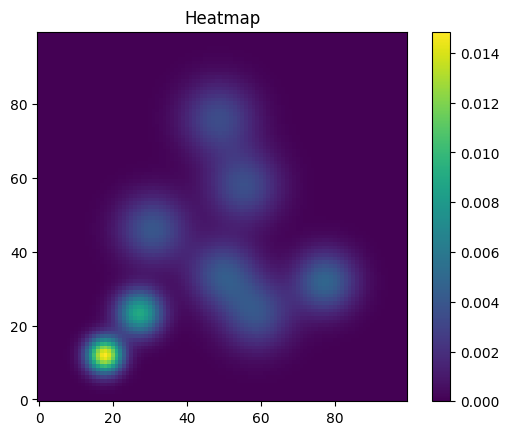

In [7]:
env.gen_heatmap()

In [ ]:
# 2 - We define the needed modules (neural networks).
# The environment has a preprocessor attribute, which is used to preprocess the state before feeding it to the policy estimator
module_PF = MLP(
    input_dim=env.preprocessor.output_dim,
    output_dim=env.n_actions
)  # Neural network for the forward policy, with as many outputs as there are actions
module_PB = MLP(
    input_dim=env.preprocessor.output_dim,
    output_dim=env.n_actions - 1,
    trunk=module_PF.trunk  # We share all the parameters of P_F and P_B, except for the last layer
)
# 3 - We define the estimators.
pf_estimator = DiscretePolicyEstimator(module_PF, env.n_actions, is_backward=False, preprocessor=env.preprocessor)
pb_estimator = DiscretePolicyEstimator(module_PB, env.n_actions, is_backward=True, preprocessor=env.preprocessor)
# 4 - We define the GFlowNet.
gfn = TBGFlowNet(logZ=0., pf=pf_estimator, pb=pb_estimator)  # We initialize logZ to 0
# 5 - We define the sampler and the optimizer.
sampler = Sampler(estimator=pf_estimator)  # We use an on-policy sampler, based on the forward policy
# Different policy parameters can have their own LR.
# Log Z gets dedicated learning rate (typically higher).
optimizer = torch.optim.Adam(gfn.pf_pb_parameters(), lr=1e-3)
optimizer.add_param_group({"params": gfn.logz_parameters(), "lr": 1e-1})

In [ ]:
# 6 - We train the GFlowNet for 1000 iterations, with 16 trajectories per iteration
for i in (pbar := tqdm(range(1000))):
    trajectories = sampler.sample_trajectories(env=env, n=16)
    optimizer.zero_grad()
    loss = gfn.loss(env, trajectories)
    loss.backward()
    optimizer.step()
    if i % 25 == 0:
        pbar.set_postfix({"loss": loss.item()})

100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s, loss=1.02]


In [ ]:
trajectories = sampler.sample_trajectories(env=env, n=10000)

In [ ]:
final_states = get_final_states(trajectories, env)

In [ ]:
samples_true_distribution = env.sample_states_from_distribution(10000)

In [ ]:
env.plot_samples(final_states)

AssertionError: 

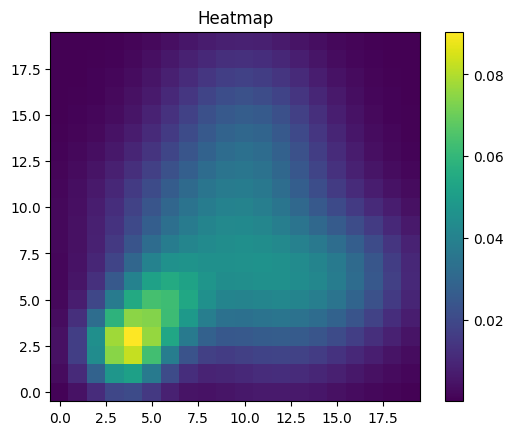

In [ ]:
env.gen_heatmap()

Calculating KL Divergence

In [ ]:
kl1, phi1 = compute_KL(samples_true_distribution.tensor.float(), final_states.tensor.float())

Epoch 100/200, KL Divergence Estimate: 2.4930
Epoch 200/200, KL Divergence Estimate: 4.1264


In [ ]:
kl2, phi2 = compute_KL(final_states.tensor.float(), samples_true_distribution.tensor.float())

Epoch 100/200, KL Divergence Estimate: 1.4078
Epoch 200/200, KL Divergence Estimate: 1.6018


Check if there is overfitting

In [ ]:
calc_KL_using_model(phi1, env.sample_states_from_distribution(10000).tensor.float(), final_states.tensor.float(), no_grad=True)

tensor(4.0458)

In [ ]:
kl, _ = compute_KL(env.sample_states_from_distribution(10000).tensor.float(), env.sample_states_from_distribution(10000).tensor.float())

Epoch 100/200, KL Divergence Estimate: 0.0021
Epoch 200/200, KL Divergence Estimate: 0.0030
